---
# INFO-H600 - Computing Foundations of Data Sciences

## Team 14 : 

Roman Lešický, Theo Abraham, Kevin Straatman, Lara Hansen, Grégoire Van den Eynde and Nicolas Roux

Version of python : 3.11.14 | packaged by conda-forge 

---

# Library:

###### The download environment.txt is present within the Github repository of the project https://github.com/RomanLesicky/Data_Science_Project_INFO_H600

### How path's are handled in this project:

In [1]:
from pathlib import Path # We are using the pathlib library for our paths 

# The way the code works is that we first locate the project's root
project_root = Path.cwd().resolve()

# Then we make a variable which hall be used as our data directory path which is sued for everyone in this project 
# For steps 2 till 5 included.

data_dir = project_root / "data" 

# Simple print for as a sanity check
print("Project root:", project_root)
print("Data dir:", data_dir)

Project root: C:\Users\roman\Desktop\Master - ULB\2nd year\Q1\Intro Data Sc\Data_Science_Project_INFO_H600
Data dir: C:\Users\roman\Desktop\Master - ULB\2nd year\Q1\Intro Data Sc\Data_Science_Project_INFO_H600\data


### Rest of the library:

In [2]:
from pyspark.sql import SparkSession, functions
from pyspark.sql.functions import mean, round

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

#! To be continued ofc 

---

# Overview of the project :

# `WIP`

---

# Task 1:

`TBD`

# DO NOT FORGET TO DO THE DOCUMENTATION in the `PDF`

### 1.0 Set-up of the SparkSession

In [3]:
# Int this cell we initialise a SparkSession, which can be reused.
# An important part of this code is that indicating to Spark to run all available CPU cores, for each task utilizing Spark.
# Therefore, the use of the code has been warned that when they are running cell which are Spark related this will utilize their whole CPU.
# The reason for doing this is that it gives us parallelism without needing a proper cluster
# Additionally, for larger file size we are allocating 16gb for the heap for the driver and executors (JVM), 200 of shuffles is reasonable and works for larger files 

spark = (SparkSession.builder.appName("MillionPlaylistProject").master("local[*]").config("spark.driver.memory", "16g")      
    .config("spark.executor.memory", "16g").config("spark.driver.maxResultSize", "4g").config("spark.sql.shuffle.partitions", "200").getOrCreate())

spark  # Just for postery we display the session 

### 1.1 Reading JSON slices into raw DataFrames using Spark

In [4]:
"""
This is an important part of the project which needs to be addressed. 

The question "How many slice files / slices do we want to read?" needs to be asked since this determined the trade-off between scalability and practical runtime.
Essentially, the answer to that question is having a sufficient amount of data that our metrics will be good whilst not calculating until forever. 

As a group we have decide to hardcode the value 5 for demonstration purposes, this means that we shall ony use mpd.slice.0 to 4999 so only about 5k playlists. 
The sole reason for this specific value is that it small enough to run very fast and yet demonstrate that the pipeline works. 
Additionally the use can adapt this number via the global variable `NUMBER_OF_SLICES`, but they shall keep in mind the that they are using all the cores of their CPU for this. 

That being said, for practical reasons which concern task's 3 and 4 (5 too) we shall use a dataset that contains 50 slices meaning 50 thousand playlists. 
This value does provides enough data to obtain stable aggregate statistics and similarity scores while keeping computation times manageable on a single machine.

Here we do not use a randomized method to chose the slices, since the data at hand is not ordered nor are we worried with a certain bias since we shall be using the 50k 
version for the actual metric determination. 

For context:

Running the 5k version uses only a couple of gb of ram, whilst using the 50k slice size takes about 14 gb of ram.

"""

# So this global variable is to be changed if one desires for a higher number of slices 
# This is very IMPORTANT this number must not be above 1000, since the database provides only a 1000 slices and could cause an Indexing error.
# If the user choses to put 1000 this represents the entire 32.1 Gb of data which is the full database.
NUMBER_OF_SLICES = 5

# This is the file path to the original Million Playlist Dataset to be used only in this Task, for the rest of the project the data_dir variable is meant to be used.
# This dataset will never be published to github since it's under the .gitignore file. 
data_dir_MGD_Original_Data = project_root / "data_Million_Playlist_Dataset" 

# Function to allow for numeric sorting and not str-related sorting, essentially this function will be used as the key parameter when using the sorted function

def slice_start_key_numeric(path: Path) -> int:
    """
    So, this function allows to extract the numeric "starting" index from filenames. 
    This allows to sort slices in the correct numeric order.
    """
    name = path.name # As an example, for mpd.slice.1000-1999.json
    
    # Here we will split to get the middle and starting string 
    the_numeric_value = name.split(".")[2] # this will split in function of "." so we get a list of ["mpd", "slice", "1000-1999", "json"] here we want 1000-1999 so [2]
    starting_string = the_numeric_value.split("-")[0] # here we split again and we also get a list but we only want the starting string so [0]
    
    # And we return the string into an integer to ger a proper numeric sorting 
    return int(starting_string) 

# Here we load all the "mpd.slice.*.json" type files which we sort in function of their numeric values  
# This creates a list of ordered Path object from all the MDP slice's.
all_slices_of_the_playlists = sorted(data_dir_MGD_Original_Data.glob("mpd.slice.*.json"),key=slice_start_key_numeric) # Here we do use the helper function slice_start_key_numeric as detailed above 

# We build a list of inputs paths for Spark, which we also use for printing the MPD files as a precaution 
input_paths = [str(path) for path in all_slices_of_the_playlists[:NUMBER_OF_SLICES]]

# The printing 
print(f"\nThe number of slices which was inputted by the user = {NUMBER_OF_SLICES}:")
for paths in input_paths:
    print("  ", paths)

# So, here we do start the actual PySpark pipeline where we read the selected slice files as a single Spark DataFrame.
# In here each of the files has the structure: {"info": {...}, "playlists": [ {...}, {...}, ... ]}
playlists_unedited_DataFrame = (spark.read.option("multiLine", True).json(input_paths))

# This means that we can directly parse nested multi-line JSON into a structured DataFrame, so we don’t need to write manual parsing code which would need to be done with Dask.


The number of slices which was inputted by the user = 5:
   C:\Users\roman\Desktop\Master - ULB\2nd year\Q1\Intro Data Sc\Data_Science_Project_INFO_H600\data_Million_Playlist_Dataset\mpd.slice.0-999.json
   C:\Users\roman\Desktop\Master - ULB\2nd year\Q1\Intro Data Sc\Data_Science_Project_INFO_H600\data_Million_Playlist_Dataset\mpd.slice.1000-1999.json
   C:\Users\roman\Desktop\Master - ULB\2nd year\Q1\Intro Data Sc\Data_Science_Project_INFO_H600\data_Million_Playlist_Dataset\mpd.slice.2000-2999.json
   C:\Users\roman\Desktop\Master - ULB\2nd year\Q1\Intro Data Sc\Data_Science_Project_INFO_H600\data_Million_Playlist_Dataset\mpd.slice.3000-3999.json
   C:\Users\roman\Desktop\Master - ULB\2nd year\Q1\Intro Data Sc\Data_Science_Project_INFO_H600\data_Million_Playlist_Dataset\mpd.slice.4000-4999.json


### 1.2 Flattening pipeline 

# Add more infos here cuz this is a bit meager 

> Note: Since our pipeline doesn't run on the entire 32.1 GB but rather on a sub-sample of a couple of slices (50 max) we rely on Spark's built-in schema inference. If we processed all 35 GB or ran on a cluster, we would define an explicit StructType schema to avoid an extra pass over the data.

In [5]:
"""
This second step of Task 1 consists in a flattening pipeline: we take the slice-level JSON files, extract all playlists, 
and then transform them into a final table with one row per (playlist, track).

From the 1.1 point we ended up with `playlists_unedited_DataFrame` which is a single dataframe "shape" according to how many `NUMBER_OF_SLICES`
the user has chosen. The data that is stored here corresponds to one row per JSON slice file.

Where each row has:
- an `info` struct, and

- a `playlists` array, where each element is a playlist with its own fields (pid, name, num_tracks, tracks, ...) 

For the remainder of the Tasks in this project it is much more convenient to work with "flat" tables rather 
than nested arrays and structs. Therefore we shall be making two table:

1) The first one named playlist-level table, which contains: 

   - one row per playlist
   - 9 columns: pid, name,collaborative,modified_atm,num_tracks, num_albums, num_followers, duration_ms and tracks 
   - This last `tracks` column still stores, for each playlist, the full array of its track entries. We will use it in the next step 
     to create one row per (playlist, track), and it also lets us easily reconstruct the original order of tracks if needed.


2) And a second one, named playlist-track table, which consists of:

   - one row per (playlist, track)
   - 15 columns: same information as the previous one, but we do not have tracks but tracks_pos, track_uri, track_name, artist_uri, artist_name,
                 album_uri, album_name, track_duration_ms

Essentially, the objective of these 2 tables is that we have a "normalized" outlook on the original data that we downloaded. Where:

- `playlists_flat_DataFrame` is a "playlist type" table which mainly contains information about the Playlist themselves 
                             from which specific Playlist metrics can be derived 
                             
- `playlist_track_DataFrame` in the same spirit but for tracks related information 

This helps us to:
- compute aggregate statistics in Task 2, 
- building track similarity from co-occurrences in playlists (Task 3),
- building playlist similarity (Task 4),
- and make a playlist continuation model (Task 5)

As briefly discussed in the markdown cell for section 1.2, we rely on Spark's built-in schema inference for the JSON input. The library inspects the JSON 
files and automatically infers field names and data types (string, long, array, struct, ...). We opted for this approach rather than defining an explicit 
JSON schema because we are not processing the full 32.1 GB of data, and therefore we do not strictly need very fine-grained control over every data type.

We are aware that if this this project needed all the data then a JSON scheme like `StructType` would have been necessary. Which would avoids an
extra pass of schema inference, making the job more robust against slight variations in the input.

In our particular setting, the inferred schema is stable across slices (even for a 50k-playlist subset), so we accept this trade-off between convenience and strictness.
"""

# Firstly we build the `playlists_flat_DataFrame` table: we explode the `playlists` array so that each playlist in each slice becomes its own row,
# and then we select only the playlist-level fields we need (pid, name, counts, duration, tracks).

playlists_DataFrame = playlists_unedited_DataFrame.select(
    functions.explode("playlists").alias("playlist"))

# From each `playlist` struct, we will only select the "playlist" related fields and `tracks` too.

playlists_flat_DataFrame = playlists_DataFrame.select(
    functions.col("playlist.pid").alias("pid"),                 # unique playlist id
    functions.col("playlist.name").alias("name"),               # playlist name
    functions.col("playlist.collaborative").alias("collaborative"),
    functions.col("playlist.modified_at").alias("modified_at"), # last modification timestamp
    functions.col("playlist.num_tracks").alias("num_tracks"),   # number of tracks in the playlist
    functions.col("playlist.num_albums").alias("num_albums"),   # number of distinct albums
    functions.col("playlist.num_followers").alias("num_followers"),
    functions.col("playlist.duration_ms").alias("duration_ms"), # total duration of the playlist
    functions.col("playlist.tracks").alias("tracks")            # still an array of track structs
)

# Secondly, we build the `playlist_track_DataFrame` table in a similar spirit: we explode the `tracks` array inside each playlist 
# and then flatten the nested `track` struct into explicit columns so that each row corresponds to a single (playlist, track) pair with all its metadata.

playlist_track_DataFrame = playlists_flat_DataFrame.select(
    functions.col("pid"),
    functions.col("name").alias("playlist_name"),
    functions.col("num_tracks"),
    functions.col("num_albums"),
    functions.col("num_followers"),
    functions.col("modified_at"),
    functions.col("duration_ms").alias("playlist_duration_ms"),
    functions.explode("tracks").alias("track")   # so here we explode the tracks array to make one row per track
)

# Here the `track` column is still a struct (pos, track_uri, track_name, artist, album, ...), so it needs to be flattened into individual columns, 
# so that each row is a fully explicit (playlist, track) record with all relevant information.

playlist_track_DataFrame = playlist_track_DataFrame.select(
    functions.col("pid"),
    functions.col("playlist_name"),
    functions.col("num_tracks"),
    functions.col("num_albums"),
    functions.col("num_followers"),
    functions.col("modified_at"),
    functions.col("playlist_duration_ms"),

    functions.col("track.pos").alias("track_pos"),             # position of the track in the playlist
    functions.col("track.track_uri").alias("track_uri"),       # Spotify track URI
    functions.col("track.track_name").alias("track_name"),     # track title
    functions.col("track.artist_uri").alias("artist_uri"),     # Spotify artist URI
    functions.col("track.artist_name").alias("artist_name"),   # artist name
    functions.col("track.album_uri").alias("album_uri"),       # Spotify album URI
    functions.col("track.album_name").alias("album_name"),     # album name
    functions.col("track.duration_ms").alias("track_duration_ms")  # duration of the specific track
)


#### 1.2.1 Scheme of  `playlist-level table` and `playlist–track table`:


In [6]:
print("Schema of playlist-level table:" + "\n")
playlists_flat_DataFrame.printSchema()

print("\nExample of 5 playlists:")
playlists_flat_DataFrame.show(5, truncate=False)

Schema of playlist-level table:

root
 |-- pid: long (nullable = true)
 |-- name: string (nullable = true)
 |-- collaborative: string (nullable = true)
 |-- modified_at: long (nullable = true)
 |-- num_tracks: long (nullable = true)
 |-- num_albums: long (nullable = true)
 |-- num_followers: long (nullable = true)
 |-- duration_ms: long (nullable = true)
 |-- tracks: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- album_name: string (nullable = true)
 |    |    |-- album_uri: string (nullable = true)
 |    |    |-- artist_name: string (nullable = true)
 |    |    |-- artist_uri: string (nullable = true)
 |    |    |-- duration_ms: long (nullable = true)
 |    |    |-- pos: long (nullable = true)
 |    |    |-- track_name: string (nullable = true)
 |    |    |-- track_uri: string (nullable = true)


Example of 5 playlists:
+----+--------+-------------+-----------+----------+----------+-------------+-----------+--------------------------------------

In [7]:
print("\nSchema of playlist-track table:" + "\n")
playlist_track_DataFrame.printSchema()

print("\nExample of 5 playlist-track rows:")
playlist_track_DataFrame.show(5, truncate=False)


Schema of playlist-track table:

root
 |-- pid: long (nullable = true)
 |-- playlist_name: string (nullable = true)
 |-- num_tracks: long (nullable = true)
 |-- num_albums: long (nullable = true)
 |-- num_followers: long (nullable = true)
 |-- modified_at: long (nullable = true)
 |-- playlist_duration_ms: long (nullable = true)
 |-- track_pos: long (nullable = true)
 |-- track_uri: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- artist_uri: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- album_uri: string (nullable = true)
 |-- album_name: string (nullable = true)
 |-- track_duration_ms: long (nullable = true)


Example of 5 playlist-track rows:
+----+-------------+----------+----------+-------------+-----------+--------------------+---------+------------------------------------+----------------------------+-------------------------------------+----------------------------+------------------------------------+---------------------------

### 1.3 Saving flattened DataFrames locally 

`To not run if one doesn't want to locally save the dataframes`

Additionally, to make this cell of code work the user needs to have winutils.exe and hadoop.dll installed locally. This can be found on this github page: 

- https://github.com/cdarlint/winutils

The version which was used for this project was hadoop-3.3.6.

In [6]:
"""
This third sub-part of Task 1 is about saving the flattened DataFrames for later Tasks so that we do not have to 
re-do the whole Step 1 pipeline more than once. This pipeline is very swift for the 5k example but it gets more and more 
heavy when increasing `NUMBER_OF_SLICES`.
"""

# NUMBER_OF_SLICES is defined in Section 1.1

# Here we have a very simple if/else code to decide on the folder's name based on NUMBER_OF_SLICES
if NUMBER_OF_SLICES >= 1000:  # if the user inputted 1000 then that corresponds to the full playlist dataset
    folder_name = "Full_Playlist"
else:  # otherwise we add that specific number as part of the folder name
    folder_name = f"{NUMBER_OF_SLICES}k_Playlists"

# Here we define the correct path
post_task1_dir = project_root / "data_post_Task_1" / folder_name

# Here we use mkdir to make it
post_task1_dir.mkdir(parents=True, exist_ok=True)

# Here is where we save the DataFrames produced in sections 1.1 and 1.2.
# For the playlist-level table, we drop the `tracks` array column to keep only playlist metadata.
# This needs to be done to safely save larger files such as 50k otherwise the code keeps crashing, crucially dropping the task 
# isn't the worst idea since in the playlist related table we do not need these information since they are all track related. 
# And finally all track-level information is already stored explicitly in `playlist_track_DataFrame`, which we also save.

playlists_flat_out = post_task1_dir / "playlists_flat"
playlist_track_out = post_task1_dir / "playlist_track"

# Drop the heavy `tracks` array before writing to avoid OutOfMemory errors for larger NUMBER_OF_SLICES
playlists_flat_to_save = playlists_flat_DataFrame.drop("tracks")

playlists_flat_to_save.write.mode("overwrite").parquet(str(playlists_flat_out))
playlist_track_DataFrame.write.mode("overwrite").parquet(str(playlist_track_out))
# We are in overwrite mode so each time this code cell is run it overwrites what is already present,
# so the user should be cautious.

# Just to make things very clear 
print("\nSaved playlist tables to:")
print(playlists_flat_out)
print(playlist_track_out)



Saved playlist tables to:
C:\Users\roman\Desktop\Master - ULB\2nd year\Q1\Intro Data Sc\Data_Science_Project_INFO_H600\data_post_Task_1\5k_Playlists\playlists_flat
C:\Users\roman\Desktop\Master - ULB\2nd year\Q1\Intro Data Sc\Data_Science_Project_INFO_H600\data_post_Task_1\5k_Playlists\playlist_track


----

# Task 2:

# Do not forget to make the documentation (ノ ゜Д゜)ノ ︵ ┻━┻

### 2.0 Loading a spark session:

Since the `Spark` session from Step 1 is to loaded only for that specific step we need to redefine the spark session here:

In [ ]:
spark = (SparkSession.builder.appName("MillionPlaylistProject_Tasks2to5").master("local[*]").getOrCreate())

# Again we are using all cores of the CPU but are not allocating as much memory so this should be relatively safe to run resource-wise.

### 2.1 Loading processed data from Task 1:

#### `5k_Playlists`

In [4]:
# data_dir is defined in the Library (top section) of this Notebook  

processed_dir = data_dir / "5k_Playlists"

# Defining the paths to the two tables that we will be using 
playlists_flat_path = processed_dir / "playlists_flat"
playlist_track_path = processed_dir / "playlist_track"  

# Just for posterity to print that where everything is 
print("playlists_flat_path:", playlists_flat_path)
print("playlist_track_path:", playlist_track_path)

# Loading DataFrames that were created using spark.read (which is the reason why we need the SparkSession) 
playlists_flat_DataFrame = spark.read.parquet(str(playlists_flat_path))
playlist_track_DataFrame = spark.read.parquet(str(playlist_track_path))

playlists_flat_path: C:\Users\roman\Desktop\Master - ULB\2nd year\Q1\Intro Data Sc\Data_Science_Project_INFO_H600\data\5k_Playlists\playlists_flat
playlist_track_path: C:\Users\roman\Desktop\Master - ULB\2nd year\Q1\Intro Data Sc\Data_Science_Project_INFO_H600\data\5k_Playlists\playlist_track


#### `50k_Playlists`

In [4]:
# The precise path where the 50k data is stored is within the data_post_Task_1 folder.
# Here we are using project_root which is also is defined in the Library (top section) of this Notebook  

data_dir_for_50k = project_root / "data_post_Task_1" / "50k_Playlists"

# Same principal as the cell above 
playlists_flat_path = data_dir_for_50k / "playlists_flat"
playlist_track_path = data_dir_for_50k / "playlist_track"  

print("playlists_flat_path:", playlists_flat_path)
print("playlist_track_path:", playlist_track_path)

playlists_flat_DataFrame_50k = spark.read.parquet(str(playlists_flat_path))
playlist_track_DataFrame_50k = spark.read.parquet(str(playlist_track_path))

playlists_flat_path: C:\Users\roman\Desktop\Master - ULB\2nd year\Q1\Intro Data Sc\Data_Science_Project_INFO_H600\data_post_Task_1\50k_Playlists\playlists_flat
playlist_track_path: C:\Users\roman\Desktop\Master - ULB\2nd year\Q1\Intro Data Sc\Data_Science_Project_INFO_H600\data_post_Task_1\50k_Playlists\playlist_track


# Add the whole  Explain how you derived the presented information.

### 2.2 Basic statistical exploration:



#### `5k_Playlists`

#### `50k_Playlists`

#### Track statistics:

In [30]:

# Here we shall calculate the various statistics using functions from spark
number_of_playlists = playlists_flat_DataFrame_50k.count()
total_number_of_rows      = playlist_track_DataFrame_50k.count()
number_of_unique_tracks    = playlist_track_DataFrame_50k.select("track_uri").distinct().count()
number_of_unique_artists   = playlist_track_DataFrame_50k.select("artist_uri").distinct().count()
number_of_unique_albums    = playlist_track_DataFrame_50k.select("album_uri").distinct().count()

average_number_of_followers = playlists_flat_DataFrame_50k.select(mean("num_followers")).first()[0]
average_number_of_tracks    = playlists_flat_DataFrame_50k.select(mean("num_tracks")).first()[0]

average_duration_in_mins  = playlist_track_DataFrame_50k.select(round(mean("track_duration_ms"))).first()[0] / 60000

# Pandas dataframe to present the basic statistics 
Summary_DataFrame_Tracks = pd.DataFrame({
    "Metric": ["Number of Playlists","Total Rows","Unique Tracks","Unique Artists","Unique Albums","Average nmb follower per playlist","Average tracks per playlist","Average track duration (mins)"],
    "Value": [number_of_playlists, total_number_of_rows, number_of_unique_tracks, number_of_unique_artists,number_of_unique_albums,average_number_of_followers, average_number_of_tracks,average_duration_in_mins]
    })

Summary_DataFrame_Tracks

,Metric,Value
0,Number of Playlists,5.000000e+04
1,Total Rows,3.344374e+06
2,Unique Tracks,4.618800e+05
3,Unique Artists,8.048300e+04
4,Unique Albums,1.956000e+05
5,Average nmb follower per playlist,2.623580e+00
6,Average tracks per playlist,6.688748e+01
7,Average track duration (mins),3.910800e+00


#### Playlist statistics:

In [ ]:
# Same principal as above 
number_of_playlists = playlists_flat_DataFrame_50k.count()
number_of_unique_names = playlists_flat_DataFrame_50k.select("name").distinct().count()

average_albums_per_playlist = playlists_flat_DataFrame_50k.select(mean("num_albums")).first()[0]

# This is in hours since the value would be too big in minutes !!!
raw_duration_hours = playlists_flat_DataFrame_50k.select(mean("duration_ms")).first()[0] / 3600000
average_playlist_duration_hours = np.round(raw_duration_hours, 4) # For this one the round didn't want to work directly so need to do it in two times 

Summary_DataFrame_Playlists = pd.DataFrame({
    "Metric": ["Number of Playlists", "Unique Playlist Names", "Average albums per playlist", "Average playlist duration (hours)"],
    "Value": [number_of_playlists, number_of_unique_names, average_albums_per_playlist, average_playlist_duration_hours]
})

Summary_DataFrame_Playlists

,Metric,Value
0,Number of Playlists,50000.00000
1,Unique Playlist Names,19156.00000
2,Average albums per playlist,49.92954
3,Average playlist duration (hours),4.35970


### 2.3 General visualization of variables:



#### `5k_Playlists`


#### `50k_Playlists`


#### 2.3.1 Distribution of playlist length and track frequency


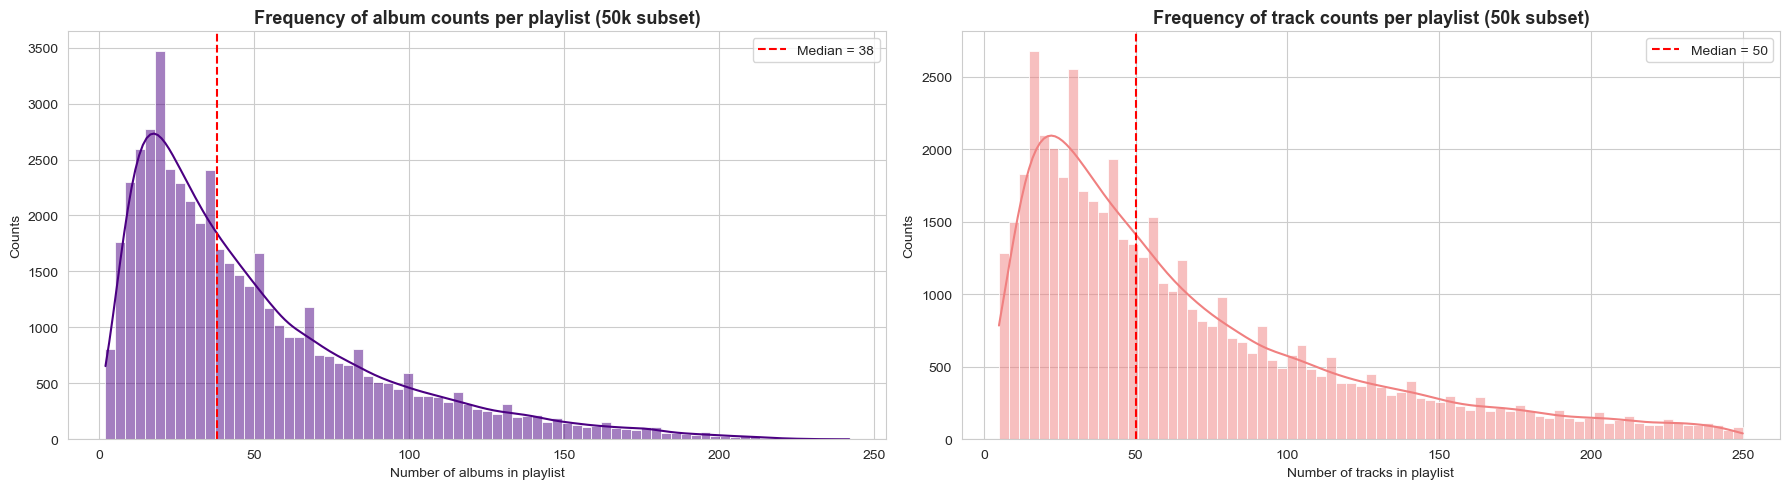

In [9]:

# This will be an universal theme, the graphics look better with a white grid pattern as background 
sns.set_style("whitegrid")

# --- Step 1: Spark → Pandas with just what we need ---
# Here we use Spark to select only the num_tracks and num_albums columns from our playlists_flat_DataFrame_50k dataframe 
# And importantly convert this to a Pandas dataframe which Seahorse does very much like. 
# Additionally, the majority of the plotting for Task 2 will be one using Seahorse.

playlist_DataFrame_generic_infos = (playlists_flat_DataFrame_50k
    .select("num_tracks", "num_albums")
    .toPandas()) 

# Adding the median value is a nice touch in the graphic, not the mean since this could be affected by outliers 
tracks_median = playlist_DataFrame_generic_infos["num_tracks"].median()
albums_median = playlist_DataFrame_generic_infos["num_albums"].median()

# This first cell is meant to show the country / frequency distribution of "num_tracks" and "num_albums"
# For this we initialize two subplots using Matplotlib but the actual plotting is done by sns. 

figure, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.histplot(data=playlist_DataFrame_generic_infos,
    x="num_albums",
    bins=75, # This is a arbitrary but 25 seems to produce a correct distribution graphic 
    kde=True, # We add a smooth curve on top of histogram
    ax=axes[0],
    color="#4B0082") # All the colors were chosen using an RGB pallette website 

# Here we added the Median vertical line 
axes[0].axvline(albums_median, color="#FF0000", linestyle="--",label=f"Median = {albums_median:.0f}")

# The rest is mainly graphic annotation:
axes[0].set_title("Frequency of album counts per playlist (50k subset)", fontsize=13, fontweight="bold")
axes[0].set_xlabel("Number of albums in playlist")
axes[0].set_ylabel("Counts")
axes[0].legend()

# Here we have the same logic for the 2nd histogram for tracks 
sns.histplot(
    data=playlist_DataFrame_generic_infos,
    x="num_tracks",
    bins=75,
    kde=True,
    ax=axes[1],
    color="#F08080")

axes[1].axvline(tracks_median, color="#FF0000", linestyle="--",label=f"Median = {tracks_median:.0f}")
axes[1].set_title("Frequency of track counts per playlist (50k subset)", fontsize=13, fontweight="bold")
axes[1].set_xlabel("Number of tracks in playlist")
axes[1].set_ylabel("Counts")
axes[1].legend()

plt.tight_layout()
plt.show()


#### 2.3.2 Distribution of playlist size and diversity


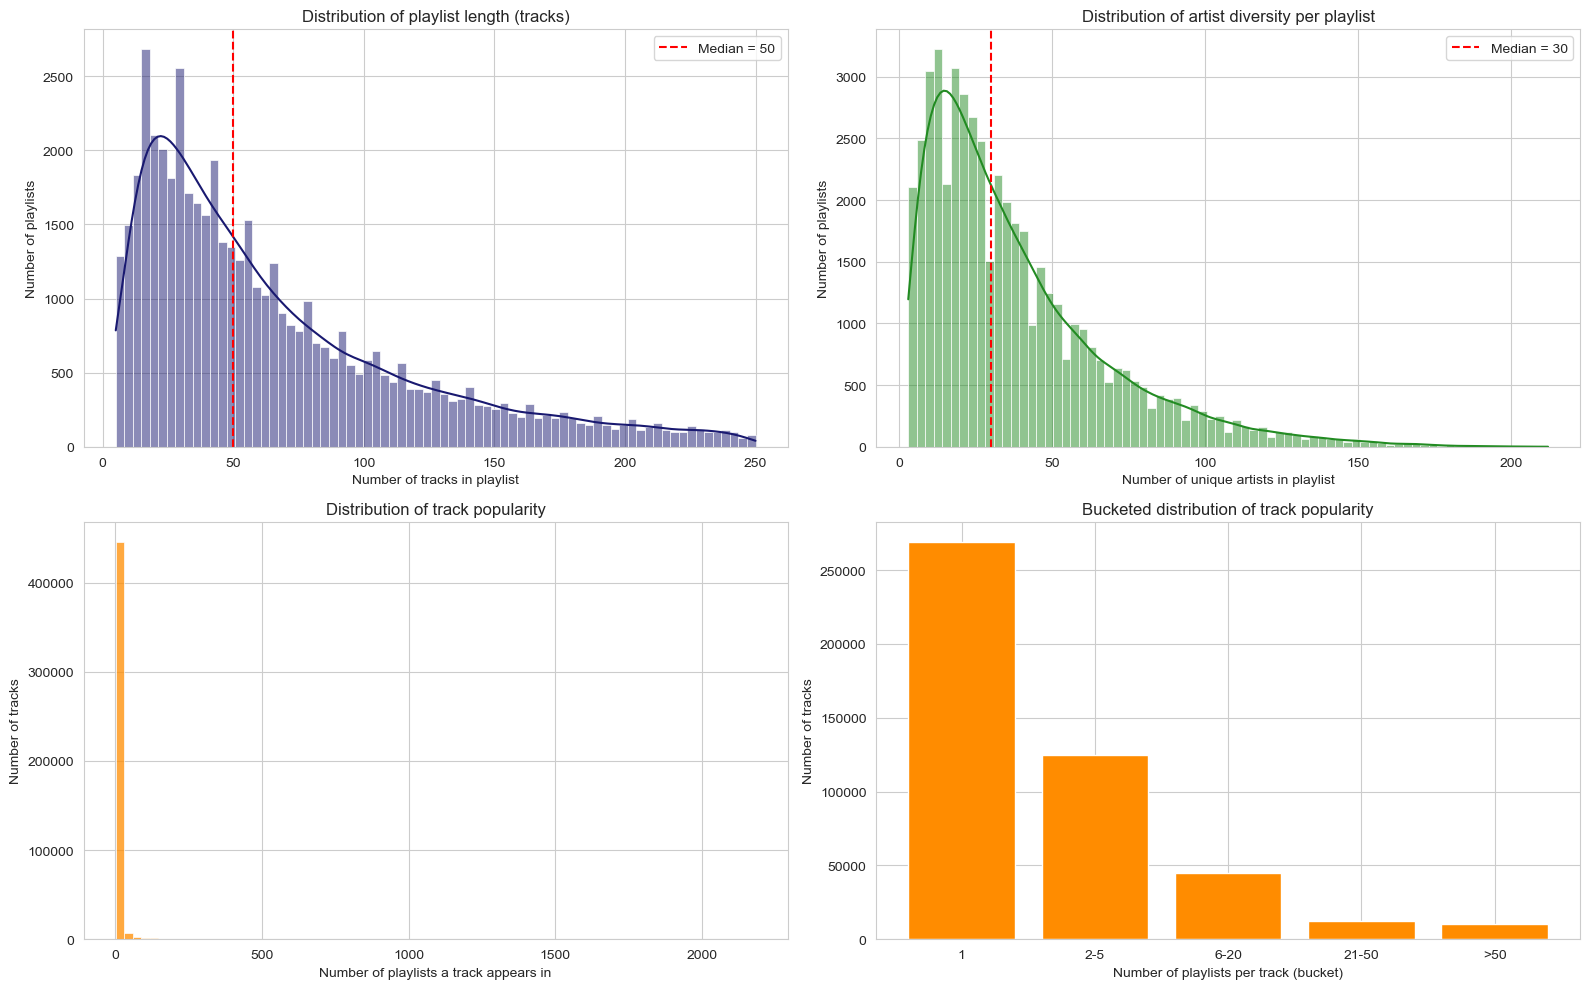

In [ ]:
# Just like before 
sns.set_style("whitegrid")

# Here we shall make the dataframes which contain the "playlist" interesting plotting wise information:
# So the upper graphics:

# Here we take the playlist table, and select the pid and num_tracks which we need to plot the distribution of playlist lengths (number of tracks per playlist) in the upper-left panel
# The reason we keep pid is that it's going to be used for mergning the final Pandas dataframe. 
playlist_informations = (playlists_flat_DataFrame_50k
    .select("pid", "num_tracks")
    )

# Than from the track table, we group by PID so group rows by playlist ID's (`pid`), than we count the unique artist ID's (`artist_uri`)
# , and at the end we rename into number_of_unique_artists

artist_diversity_from_track_information = (playlist_track_DataFrame_50k
    .groupBy("pid").agg(functions.countDistinct("artist_uri").alias("number_of_unique_artists"))
)

# Here we just merge using .join using the pid, here we do an inner join to keep all the relevant information for the final Pandas dataframe 
DataFrame_for_Playlist_plotting = (
    playlist_informations
    .join(artist_diversity_from_track_information, on="pid", how="inner")
    .toPandas()
)

# Just like in the previous code cell we compute medians
tracks_median  = DataFrame_for_Playlist_plotting["num_tracks"].median()
artists_median = DataFrame_for_Playlist_plotting["number_of_unique_artists"].median()

# Here we shall make the dataframes which contain the "track" interesting plotting wise information:
# So the lower graphics:

# Here we do not need to merge two different tables, since all the relevant information are present in the track table
# So we just group_by track_uri and aggregate using pid, which we than can just transform into a Pandas table 
DataFrame_for_Track_plotting = (
    playlist_track_DataFrame_50k
    .groupBy("track_uri")
    .agg(functions.countDistinct("pid").alias("num_playlists_per_track"))
    .toPandas()
)

# Here we create the different bins since, the continuous graphic will be mainly centered around the value of 1
# THe 2184 which is the max value of "num_playlists_per_track" +1 so we capture all the values present in this column.
bins_that_we_will_use   = [1, 2, 6, 21, 51,2184]

# Here we make 5 catagorical labels, these 5 seem to be enough to spread out the data accordingly 
labels = ["1", "2-5", "6-20", "21-50", ">50"]

# Here Use pd.cut to assign each track a bucket value in the DataFrame_for_Track_plotting dataframe 

DataFrame_for_Track_plotting["bucket_values"] = pd.cut(
    DataFrame_for_Track_plotting["num_playlists_per_track"],
    bins=bins_that_we_will_use,
    right=False,
    labels=labels
)

# Simply we just count how many tracks fall in each bucket category then we sort them by order 
bucket_counts = (
    DataFrame_for_Track_plotting["bucket_values"]
    .value_counts() # So here counts(), counts by the 5 categories labels that we made  
    .sort_index() # we index so we have the right order 
)

# Plotting just like in the cell above:

figures, axes = plt.subplots(2, 2, figsize=(16, 10))

# Here we plot the upper left playlist length and median value 
sns.histplot(
    DataFrame_for_Playlist_plotting["num_tracks"],
    bins=75,
    kde=True,
    ax=axes[0, 0],
    color="#191970"
)

axes[0, 0].axvline(tracks_median,color="#FF0000",linestyle="--",linewidth=1.5,label=f"Median = {tracks_median:.0f}")
axes[0, 0].set_title("Distribution of playlist length (tracks)")
axes[0, 0].set_xlabel("Number of tracks in playlist")
axes[0, 0].set_ylabel("Number of playlists")
axes[0, 0].legend()

# Here we have the upper right graph, for artist diversity and median
sns.histplot(
    DataFrame_for_Playlist_plotting["number_of_unique_artists"],
    bins=75,
    kde=True,
    ax=axes[0, 1],
    color="#228B22"
)

axes[0, 1].axvline(artists_median,color="#FF0000",linestyle="--",linewidth=1.5,label=f"Median = {artists_median:.0f}")
axes[0, 1].set_title("Distribution of artist diversity per playlist")
axes[0, 1].set_xlabel("Number of unique artists in playlist")
axes[0, 1].set_ylabel("Number of playlists")
axes[0, 1].legend()

# Lower left graphic which ist he continuous track popularity
sns.histplot(
    DataFrame_for_Track_plotting["num_playlists_per_track"],
    bins=75,
    kde=False,
    ax=axes[1, 0],
    color="#FF8C00"
)

axes[1, 0].set_title("Distribution of track popularity")
axes[1, 0].set_xlabel("Number of playlists a track appears in")
axes[1, 0].set_ylabel("Number of tracks")
# This technically would simpler to visualize in log or ln transformation 
# But we want to keep it this way since we are doing the categorical breakdown just beside 

# And finally we have the lower right categorical track popularity
axes[1, 1].bar(
    bucket_counts.index.astype(str),
    bucket_counts.values,
    color="#FF8C00"
)

axes[1, 1].set_title("Bucketed distribution of track popularity")
axes[1, 1].set_xlabel("Number of playlists per track (bucket)")
axes[1, 1].set_ylabel("Number of tracks")

plt.tight_layout()
plt.show()



#### 2.3.3 Most frequent artists and tracks in the 50k subset

# Alterer ces codes un peu 

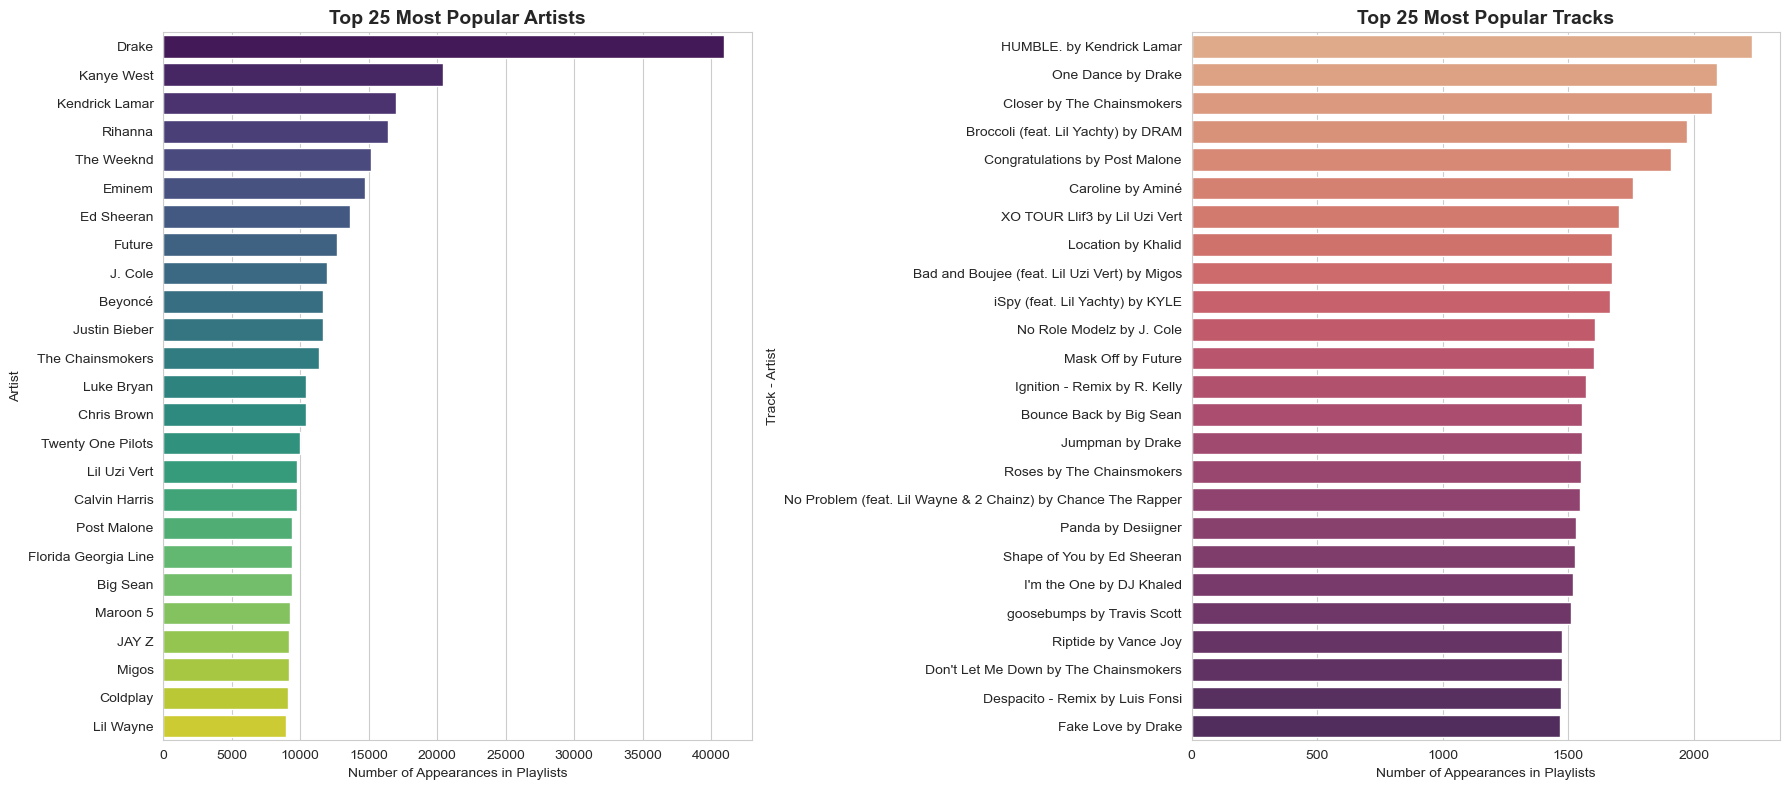

In [17]:
# Just like before 
sns.set_style("whitegrid")

# For both of these graphics we will be using track information.

# The dataframe that we define is for the trop artist's, where we  count how many times each artist appears across all playlists
Top_Aritists_DataFrame = (
    playlist_track_DataFrame_50k.groupBy("artist_name") # so we group by the artist's name 
    .count() # we count them up 
    .orderBy(functions.col("count").desc()) # we order in a descending manner  
    .limit(25) # Doing trop 25 seems to be reasonable without being too excessive  
    .toPandas()
    )

# For the top tracks we shall be suing the playlist_track_DataFrame_50k dataframe.
# This wil be grouped by both track and artist to avoid problems with the way the data are encoded (if we didn't do this we had weird results)

Top_Tracks_DataFrame =(
    playlist_track_DataFrame_50k.groupBy("track_name", "artist_name")  
    .count() # same logic as the previous dataframe 
    .orderBy(functions.col("count").desc()) 
    .limit(25) 
    .toPandas()
    )

# Here we create labels to get the title of the Song "by" name of the artist
Top_Tracks_DataFrame["label"] = Top_Tracks_DataFrame["track_name"] + " by " + Top_Tracks_DataFrame["artist_name"]

# Same visualization just like the previous cells but here we use color pallets instead of one one color to signi

figure, axes = plt.subplots(1, 2, figsize=(18, 8))

# Left top 25 artists plot 
sns.barplot(
    data=Top_Aritists_DataFrame,x="count",y="artist_name",hue="artist_name",      
    dodge=False, palette="viridis",legend=False,ax=axes[0]
)

axes[0].set_title("Top 25 Most Popular Artists", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Number of Appearances in Playlists")
axes[0].set_ylabel("Artist")

# Right top 25 tracks plot  
sns.barplot(
    data=Top_Tracks_DataFrame, x="count", y="label",hue="label",            
    dodge=False, palette="flare", legend=False,ax=axes[1]
)

axes[1].set_title("Top 25 Most Popular Tracks", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Number of Appearances in Playlists")
axes[1].set_ylabel("Track - Artist")

plt.tight_layout()
plt.show()

#### 2.3.4  Year by year distribution of playlists (2011–2017)

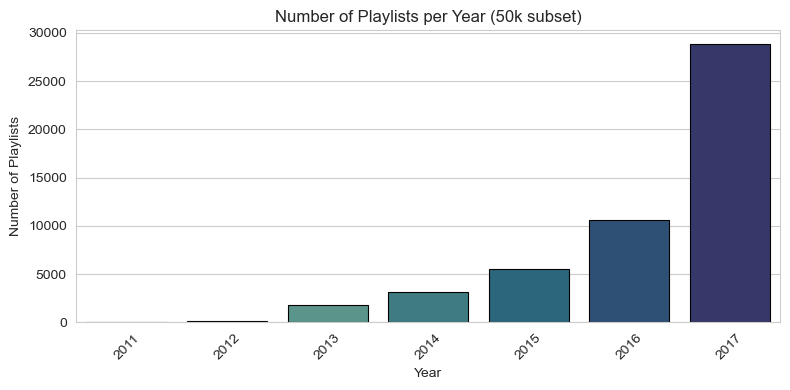

In [ ]:
# Just like before
sns.set_style("whitegrid")

# Here we ake a dataframe using playlists_flat_DataFrame_50k to contain relevant year information, since the majority of the data comes from 2017 as the graph shows.
DataFrame_Playlists_Years = (
    playlists_flat_DataFrame_50k
    .withColumn("year", functions.year(functions.from_unixtime("modified_at"))) # here we make a new column year, which is created from the unix stamp modified_at into a datatime value 
    .groupBy("year") # than we group by tis new column 
    .agg(functions.count("*").alias("number_of_playlists")) # here we aggregate on each year, where we count each row "*" for that particular year and we rename it to number_of_playlists
    .orderBy("year") # than we order by year, so into a chronological ascending way 
    .toPandas() # convert to Pandas 
)

# Same as before with sns 
plt.figure(figsize=(8, 4))

plot_of_Years = sns.barplot(
    data=DataFrame_Playlists_Years,
    x="year",
    y="number_of_playlists",
    hue="year", 
    palette="crest", # here we opted for a platte coloring than a single color 
    dodge=False,
    legend=False,
    edgecolor="black",  
    linewidth=0.8       
)

# Using Plt to complete the plot 
plt.title("Number of Playlists per Year (50k subset)")
plt.xlabel("Year")
plt.ylabel("Number of Playlists")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


---

# Task 3:

## Please load the `2.0 and 2.1 Loading processed data from Task 1:` and keep using `playlists_flat_DataFrame` and `playlist_track_DataFrame`

If you are not able to load the 50k data that is normal and y'all should ignore it as discussed in the Whatsapp message, focus on the 5k which should work if not (╯°□°）╯︵┻━┻

# This way everything is standardized  

---

# Task 4:

## Please load the `2.0 and 2.1 Loading processed data from Task 1:` and keep using `playlists_flat_DataFrame` and `playlist_track_DataFrame`

If you are not able to load the 50k data that is normal and y'all should ignore it as discussed in the Whatsapp message, focus on the 5k which should work if not (╯°□°）╯︵┻━┻

# This way everything is standardized  

---

# Task 5:

## Please load the `2.0 and 2.1 Loading processed data from Task 1:` and keep using `playlists_flat_DataFrame` and `playlist_track_DataFrame`

If you are not able to load the 50k data that is normal and y'all should ignore it as discussed in the Whatsapp message, focus on the 5k which should work if not (╯°□°）╯︵┻━┻

# This way everything is standardized  

---

# Bibliography: 

It could be nice to get a reference for the Similarity part and justifying it using a paper, this is just an idea tho 
